# __Credit Card Routing System__

This is the main notebook of the project and is divided by _ parts:
- Exploratory Data Analysis
- Data Cleansing

### Main Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import streamlit as st

# Data processing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read Data

In [2]:
# Thes lines are responsible for loading the Excel dataset and printing the head
df = pd.read_excel('data/PSP_Jan_Feb_2019.xlsx')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB


,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


### Exploratory Data Analysis

__Histogram of Distribution of Transactions__

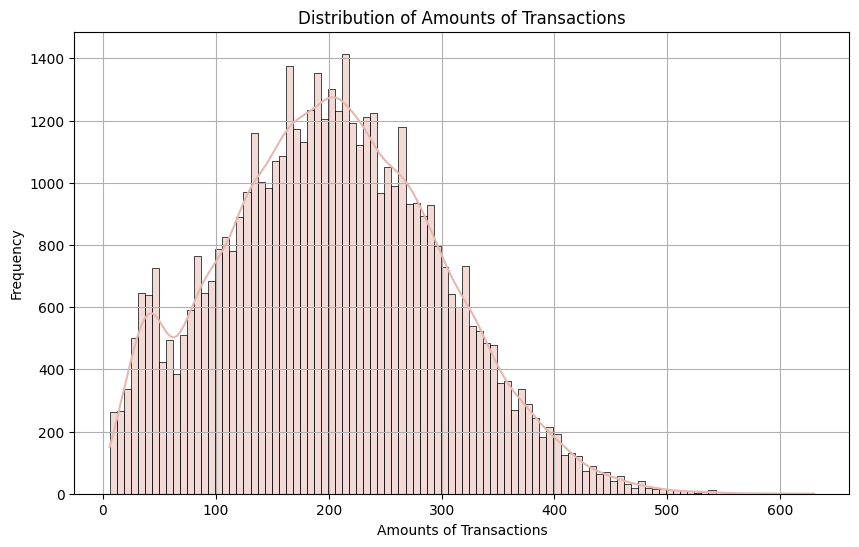

In [3]:
# This snippet is for plotting the histogram of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=100, kde=True, color='#e6b8af')
plt.title('Distribution of Amounts of Transactions')
plt.grid(True)
plt.xlabel('Amounts of Transactions')
plt.ylabel('Frequency')
plt.show()

__Bar Chart with the Success Rate (by 3D-Secure Status)__

C:\Users\imildo.sitoe\AppData\Local\Temp\ipykernel_10692\706523783.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='3D_secured', y='success', data=success_rates, palette='coolwarm')


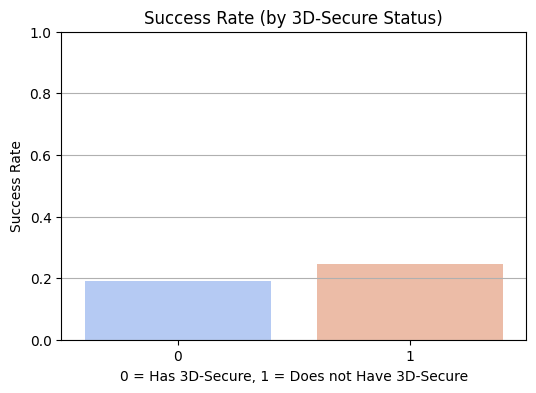

In [4]:
# This snippet is for calculating the success rate by 3D-secure status
success_rates = df.groupby('3D_secured')['success'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='3D_secured', y='success', data=success_rates, palette='coolwarm')
plt.title('Success Rate (by 3D-Secure Status)')
plt.xlabel('0 = Has 3D-Secure, 1 = Does not Have 3D-Secure')
plt.ylabel('Success Rate')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

__Bar Chart with the Transaction Success Rates (by PSP)__

C:\Users\imildo.sitoe\AppData\Local\Temp\ipykernel_10692\689061155.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PSP', y='success', data=psp_success_rates, palette='viridis')


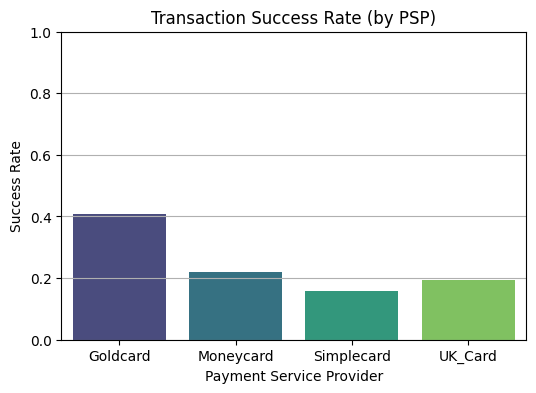

In [5]:
# Line to calculate the success rates per each PSP
psp_success_rates = df.groupby('PSP')['success'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='PSP', y='success', data=psp_success_rates, palette='viridis')
plt.title('Transaction Success Rate (by PSP)')
plt.xlabel('Payment Service Provider')
plt.ylabel('Success Rate')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

__Retry Patterns__

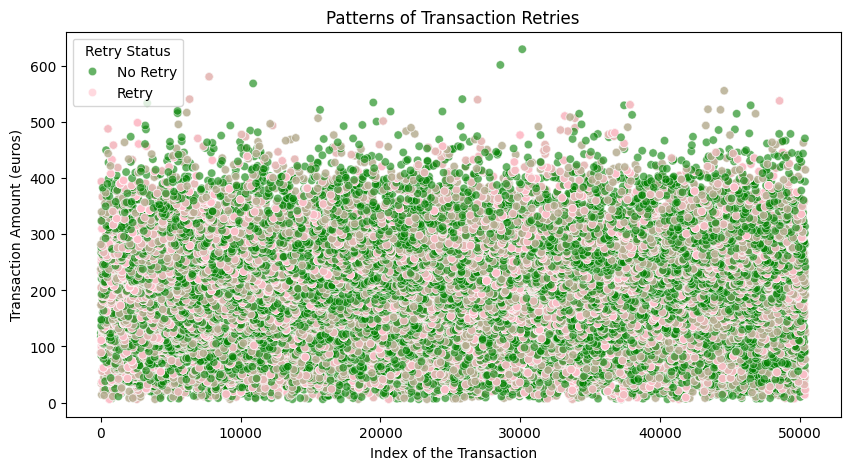

In [6]:
# Convert timestamp to datetime format
df_exploration = df
df_exploration['tmsp'] = pd.to_datetime(df_exploration['tmsp'])

# Sort values for easier comparison
df_exploration = df_exploration.sort_values(by=['country', 'amount', 'tmsp'])

# Identify retries (transactions within 1 minute with the same amount & country)
df_exploration['retry'] = (df_exploration.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds() <= 60).astype(int)

# Define color mapping explicitly
palette = {0: 'green', 1: 'pink'}

# Plot retry patterns
plt.figure(figsize=(10, 5))
scatter = sns.scatterplot(x=df_exploration.index, y=df_exploration['amount'], hue=df_exploration['retry'], data=df_exploration, palette=palette, alpha=0.6)

# Set legend labels manually
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=["No Retry", "Retry"], title="Retry Status")

plt.title('Patterns of Transaction Retries')
plt.xlabel('Index of the Transaction')
plt.ylabel('Transaction Amount (euros)')
plt.show()

### Data Preparation

__Data Cleaning__

In [7]:
df.info()

# Convert timestamp to datetime format
df['tmsp'] = pd.to_datetime(df['tmsp'])

# Fill missing categorical values with the mode
for col in ['country', 'PSP', '3D_secured', 'card']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numeric values with the median
df['amount'].fillna(df['amount'].median(), inplace=True)

# Drop duplicate transactions (keeping first occurrence)
df.drop_duplicates(inplace=True)

# Display updated data summary
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object    

C:\Users\imildo.sitoe\AppData\Local\Temp\ipykernel_10692\955798493.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\imildo.sitoe\AppData\Local\Temp\ipykernel_10692\955798493.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


__Feature Engineering__

In [8]:
# Identify retries (transactions within 1 minute with the same amount & country)
df = df.sort_values(by=['country', 'amount', 'tmsp'])
df['retry'] = (df.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds() <= 60).astype(int)

# Extract time-based features
df['hour'] = df['tmsp'].dt.hour
df['day_of_week'] = df['tmsp'].dt.dayofweek
df['month'] = df['tmsp'].dt.month

# Map 3D-secured to categorical (0 = No, 1 = Yes)
df['3D_secured'] = df['3D_secured'].astype(int)

# Encode PSPs numerically
psp_mapping = {"Moneycard": 1, "Goldcard": 2, "UK_Card": 3, "Simplecard": 4}
df['PSP_code'] = df['PSP'].map(psp_mapping)

# Transaction cost calculation (based on business rules)
psp_fees = {
    "Moneycard": {1: 5, 0: 2},
    "Goldcard": {1: 10, 0: 5},
    "UK_Card": {1: 3, 0: 1},
    "Simplecard": {1: 1, 0: 0.5}
}
df['transaction_cost'] = df.apply(lambda x: psp_fees[x['PSP']][x['success']], axis=1)

# Display updated dataset
df.head()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card,retry,hour,day_of_week,month,PSP_code,transaction_cost
9238,9238,2019-01-10 03:49:12,Austria,6,0,Moneycard,0,Diners,0,3,3,1,1,2.0
9239,9239,2019-01-10 03:49:37,Austria,6,0,Simplecard,0,Diners,1,3,3,1,4,0.5
22742,22742,2019-01-27 14:01:11,Austria,6,1,Simplecard,0,Master,0,14,6,1,4,1.0
33737,33737,2019-02-08 05:02:33,Austria,6,0,UK_Card,0,Diners,0,5,4,2,3,1.0
33738,33738,2019-02-08 05:02:37,Austria,6,0,UK_Card,0,Diners,1,5,4,2,3,1.0


__Outlier Treatment__

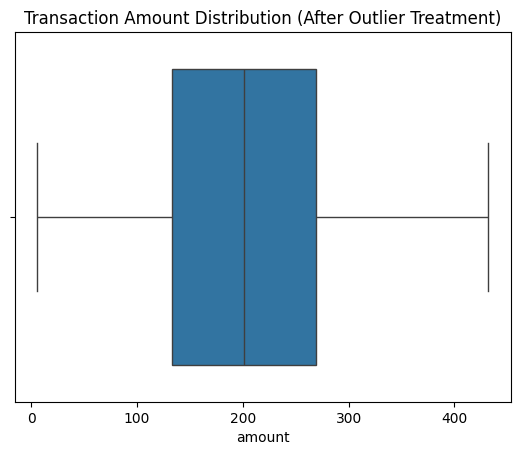

In [9]:
# Define an upper limit for transaction amounts
upper_limit = df['amount'].quantile(0.99)  # Cap at 99th percentile
df['amount'] = np.where(df['amount'] > upper_limit, upper_limit, df['amount'])

# Verify the updated amount distribution
sns.boxplot(x=df['amount'])
plt.title("Transaction Amount Distribution (After Outlier Treatment)")
plt.show()

### Modeling

__Data Preprocessing__

In [ ]:
# Define feature columns
feature_cols = ['amount', '3D_secured', 'retry', 'hour', 'day_of_week', 'month', 'PSP_code']

# Define target variable
target_col = 'success'

# Encode categorical variables (if needed)
label_enc = LabelEncoder()
df['card'] = label_enc.fit_transform(df['card'])
df['country'] = label_enc.fit_transform(df['country'])

# Final feature set
X = df[feature_cols]
y = df[target_col]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_original = X_test.copy()
# psp_column = X_test_original["PSP_code"]

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

32306    4
42315    4
41412    1
9377     3
2431     3
        ..
31982    4
46216    4
42218    4
12171    4
9644     3
Name: PSP_code, Length: 10082, dtype: int64
       amount  3D_secured  retry  hour  day_of_week  month  PSP_code
32306   207.0           0      0    18            2      2         4
42315   181.0           0      1    17            0      2         4
41412   112.0           0      0    15            6      2         1
9377    164.0           0      0     8            3      1         3
2431    316.0           0      1     0            3      1         3
...       ...         ...    ...   ...          ...    ...       ...
31982   146.0           0      0    10            2      2         4
46216   248.0           0      1    16            5      2         4
42218   302.0           0      1    15            0      2         4
12171    51.0           0      0    23            6      1         4
9644     59.0           0      0    15            3      1         3

[10082

__Baseline Model__

In [11]:
# Baseline: Predicting the most common class (majority class classifier)
most_common_class = y_train.value_counts().idxmax()
y_pred_baseline = np.full(y_test.shape, most_common_class)

# Evaluate baseline
print("Baseline Model Performance:")
print(classification_report(y_test, y_pred_baseline))

Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      8040
           1       0.00      0.00      0.00      2042

    accuracy                           0.80     10082
   macro avg       0.40      0.50      0.44     10082
weighted avg       0.64      0.80      0.71     10082



c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

__Logistic Regression__

In [12]:
# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      8040
           1       0.00      0.00      0.00      2042

    accuracy                           0.80     10082
   macro avg       0.40      0.50      0.44     10082
weighted avg       0.64      0.80      0.71     10082



c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

__Random Forest Classifier__

In [13]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      8040
           1       0.29      0.14      0.19      2042

    accuracy                           0.76     10082
   macro avg       0.55      0.53      0.52     10082
weighted avg       0.70      0.76      0.72     10082



__XGBoost Classifier__

In [14]:
# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      8040
           1       0.45      0.06      0.11      2042

    accuracy                           0.79     10082
   macro avg       0.63      0.52      0.50     10082
weighted avg       0.73      0.79      0.73     10082



c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### Tuning, Evaluation, and Selection

__Hyperparameter Tuning for All Models__

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Define hyperparameter grids
logistic_params = {
    'C': [0.01, 0.1, 1, 10], 
    'solver': ['liblinear', 'lbfgs']
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Baseline Model (Majority Class)
y_pred_baseline = [1] * len(y_test)  # Assuming most transactions succeed
print("Baseline Model Performance:")
print(classification_report(y_test, y_pred_baseline))

# Logistic Regression Tuning
logistic_grid = GridSearchCV(LogisticRegression(random_state=42), logistic_params, cv=5, scoring='f1')
logistic_grid.fit(X_train, y_train)
best_logistic = logistic_grid.best_estimator_
y_pred_logistic = best_logistic.predict(X_test)

# Random Forest Tuning
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# XGBoost Tuning
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
                         xgb_params, cv=5, scoring='f1')
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate Models
models = {
    "Baseline": y_pred_baseline,
    "Logistic Regression": y_pred_logistic,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

for model_name, y_pred in models.items():
    print(f"\n{model_name} Model Performance:")
    print(classification_report(y_test, y_pred))

c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8040
           1       0.20      1.00      0.34      2042

    accuracy                           0.20     10082
   macro avg       0.10      0.50      0.17     10082
weighted avg       0.04      0.20      0.07     10082



c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:59:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:59:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:59:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use


Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8040
           1       0.20      1.00      0.34      2042

    accuracy                           0.20     10082
   macro avg       0.10      0.50      0.17     10082
weighted avg       0.04      0.20      0.07     10082


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      8040
           1       0.00      0.00      0.00      2042

    accuracy                           0.80     10082
   macro avg       0.40      0.50      0.44     10082
weighted avg       0.64      0.80      0.71     10082


Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      8040
           1       0.29      0.14      0.19      2042

    accuracy                           0.76     10082
   macro avg       0.55  

c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imildo.sitoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

__Confusion Matrix for All Models__

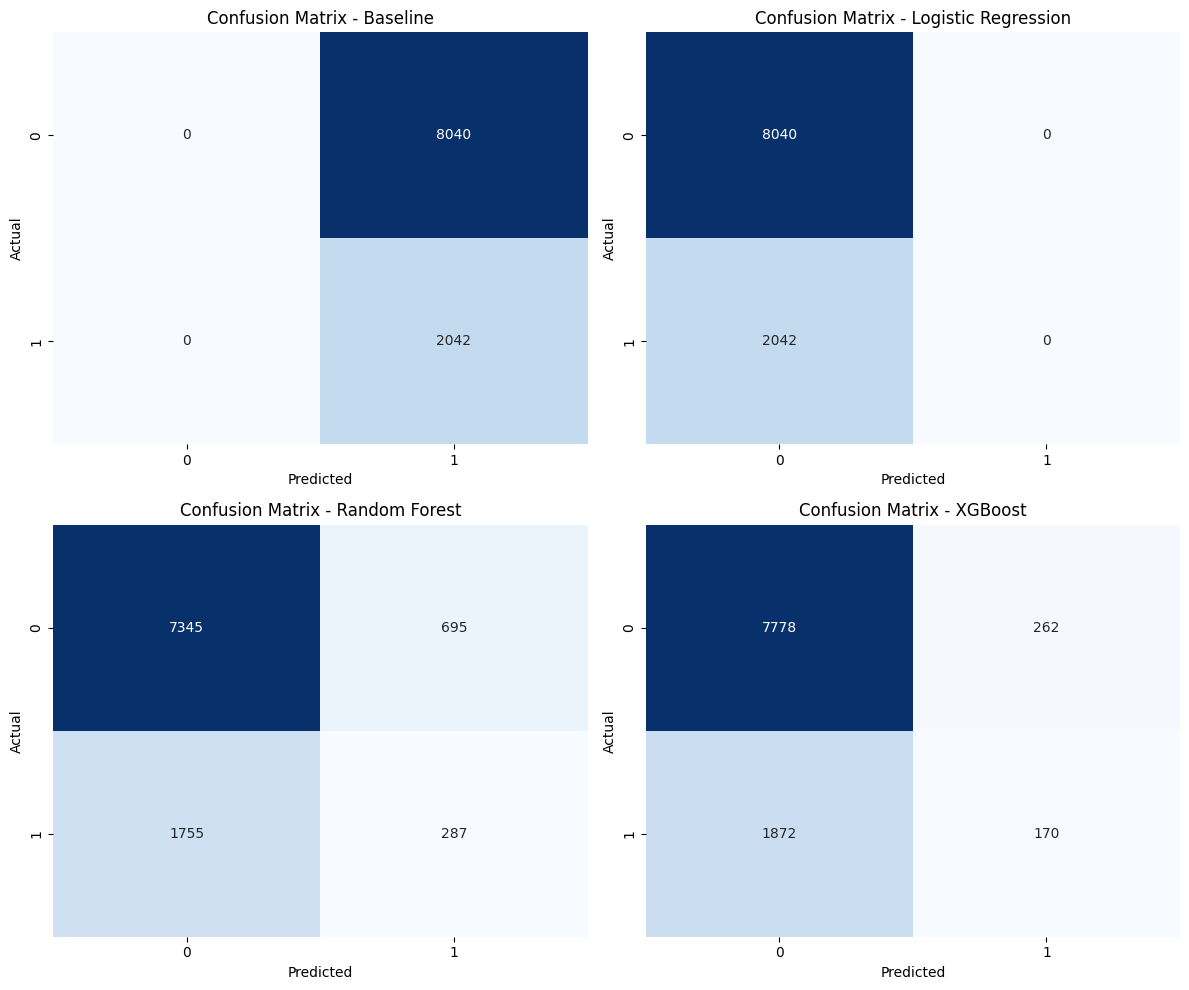

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

model_names = ["Baseline", "Logistic Regression", "Random Forest", "XGBoost"]
y_preds = [y_pred_baseline, y_pred_logistic, y_pred_rf, y_pred_xgb]

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(confusion_matrix(y_test, y_preds[i]), annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"Confusion Matrix - {model_names[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

__Comparing Model Scores and Costs of Each PSP and Selecting the Best Model__

In [ ]:
# Define PSP transaction costs (Success, Failure)
psp_costs = {
    1: {"success": 5, "failure": 2},
    2: {"success": 10, "failure": 5},
    3: {"success": 3, "failure": 1},
    4: {"success": 1, "failure": 0.5}
}

psp_mapping = {"Moneycard": 1, "Goldcard": 2, "UK_Card": 3, "Simplecard": 4}

# Function to calculate the total cost for a model
def calculate_total_cost(y_true, y_pred, psp_costs, psp_column):
    """
    Calculate total transaction cost based on confusion matrix metrics.
    """
    # Extract confusion matrix values
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Calculate total success and failure costs per transaction
    success_costs = np.where(y_pred == 1, psp_column.map(lambda x: psp_costs[x]["success"]), 0)
    failure_costs = np.where(y_pred == 0, psp_column.map(lambda x: psp_costs[x]["failure"]), 0)

    # Compute total cost
    total_cost = np.sum(success_costs) + np.sum(failure_costs)
    
    return total_cost


# Compute Costs & F1-score for Each Model
model_costs = {
    "Baseline": calculate_total_cost(y_test, y_pred_baseline, psp_costs, X_test_original["PSP_code"]),
    "Logistic Regression": calculate_total_cost(y_test, y_pred_logistic, psp_costs, X_test_original["PSP_code"]),
    "Random Forest": calculate_total_cost(y_test, y_pred_rf, psp_costs, X_test_original["PSP_code"]),
    "XGBoost": calculate_total_cost(y_test, y_pred_xgb, psp_costs, X_test_original["PSP_code"])
}

model_f1_scores = {
    "Baseline": f1_score(y_test, y_pred_baseline),
    "Logistic Regression": f1_score(y_test, y_pred_logistic),
    "Random Forest": f1_score(y_test, y_pred_rf),
    "XGBoost": f1_score(y_test, y_pred_xgb)
}

# Normalize costs (since lower cost is better, we take the inverse)
max_cost = max(model_costs.values())
normalized_costs = {model: max_cost / cost for model, cost in model_costs.items()}

# Compute final performance-cost score
final_scores = {model: model_f1_scores[model] * normalized_costs[model] for model in model_f1_scores}

# Print Results
print("\n=== Cost-Efficiency & Performance Analysis ===")
for model in model_f1_scores.keys():
    print(f"{model}:")
    print(f"   - F1-Score: {model_f1_scores[model]:.4f}")
    print(f"   - Total Cost: €{model_costs[model]:.2f}")
    print(f"   - Performance-Cost Score: {final_scores[model]:.4f}")

# Select Best Model
best_model = max(final_scores, key=final_scores.get)
print(f"\nBest Model (Considering Performance & Cost): {best_model}")

dict_keys([1, 2, 3, 4])
[4 1 3 2]

=== Cost-Efficiency & Performance Analysis ===
Baseline:
   - F1-Score: 0.3369
   - Total Cost: €0.00
   - Performance-Cost Score: inf
Logistic Regression:
   - F1-Score: 0.0000
   - Total Cost: €12907.00
   - Performance-Cost Score: 0.0000
Random Forest:
   - F1-Score: 0.1898
   - Total Cost: €15446.00
   - Performance-Cost Score: 0.1898
XGBoost:
   - F1-Score: 0.1374
   - Total Cost: €14371.50
   - Performance-Cost Score: 0.1477

Best Model (Considering Performance & Cost): Baseline


C:\Users\imildo.sitoe\AppData\Local\Temp\ipykernel_10692\967225936.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  normalized_costs = {model: max_cost / cost for model, cost in model_costs.items()}


### Evaluation

__SHAP Explanation__

In [44]:
# Initialize SHAP Explainer
explainer = shap.Explainer(best_model, X_train)  # Use the best selected model
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Baseline

__Model Deployment__

In [45]:
# Save the trained model
joblib.dump(best_model, "best_model.pkl")
print("Model saved successfully!")

Model saved successfully!


__Prediction Pipeline__

In [46]:
class PredictionPipeline:
    def __init__(self, model_path, encoder_path):
        self.model = joblib.load(model_path)  # Load trained model
        self.encoder = joblib.load(encoder_path)  # Load categorical encoder

    def preprocess(self, input_data):
        # Convert input into DataFrame
        df = pd.DataFrame([input_data], 
                          columns=["amount", "country", "card", "3D_secured"])
        
        # Apply the same encoding as in training
        df[["country", "card"]] = self.encoder.transform(df[["country", "card"]])
        
        return df

    def predict(self, input_data):
        processed_data = self.preprocess(input_data)
        prediction = self.model.predict(processed_data)
        return prediction[0]  # Return the best PSP

# Save the prediction pipeline
joblib.dump(PredictionPipeline("best_model.pkl", "encoder.pkl"), "prediction_pipeline.pkl")
print("Prediction pipeline saved successfully!")

FileNotFoundError: [Errno 2] No such file or directory: 'encoder.pkl'

__End-user GUI__

In [47]:
# Load the prediction pipeline
pipeline = joblib.load("prediction_pipeline.pkl")

st.title("Credit Card Transaction Routing Predictor")

# Input fields
amount = st.number_input("Transaction Amount (€)", min_value=0.01, step=0.01)
country = st.selectbox("Country", ["Germany", "Switzerland", "Austria"])
card = st.selectbox("Credit Card Provider", ["Master", "Visa", "Diners"])
secured = st.radio("Is the transaction 3D Secured?", [1, 0])

# Predict button
if st.button("Predict Best PSP"):
    prediction = pipeline.predict([amount, country, card, secured])
    st.success(f"Recommended PSP: {prediction}")

FileNotFoundError: [Errno 2] No such file or directory: 'prediction_pipeline.pkl'